# Datalab Cup 4: Recommender Systems
<hr>

Team Name: 沒liao恩宇

Team Member: 110062560 林子鵑、110062802 呂宸漢、110062552 周伯宇

## Environment Setting

In [2]:
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


2 Physical GPUs, 1 Logical GPUs


## Inspect the dataset

In [4]:
DATASET_PATH = 'dataset'
USERS_PATH = os.path.join(DATASET_PATH, 'users.csv')
MOVIES_PATH = os.path.join(DATASET_PATH, 'movies.csv')
RATINGS_PATH = os.path.join(DATASET_PATH, 'ratings_train.csv')


In [5]:
import pandas as pd

df_users = pd.read_csv(USERS_PATH)
df_users


,UserID,Gender,Age,Occupation,ZipCode
0,0,F,1,10,48067
1,1,M,56,16,70072
2,2,M,25,15,55117
3,3,M,45,7,02460
4,4,M,25,20,55455
...,...,...,...,...,...
6035,6035,F,25,15,32603
6036,6036,F,45,1,76006
6037,6037,F,56,1,14706
6038,6038,F,45,0,01060


In [6]:
df_movies = pd.read_csv(MOVIES_PATH)
df_movies


,MovieID,Title,Genres
0,0,Toy Story (1995),Animation|Children's|Comedy
1,1,Jumanji (1995),Adventure|Children's|Fantasy
2,2,Grumpier Old Men (1995),Comedy|Romance
3,3,Waiting to Exhale (1995),Comedy|Drama
4,4,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3947,Meet the Parents (2000),Comedy
3879,3948,Requiem for a Dream (2000),Drama
3880,3949,Tigerland (2000),Drama
3881,3950,Two Family House (2000),Drama


In [7]:
df_ratings = pd.read_csv(RATINGS_PATH)
df_ratings


,UserID,MovieID,Rating,Timestamp
0,6039,857,4,956703932
1,6039,2383,4,956703954
2,6039,592,5,956703954
3,6039,1960,4,956703977
4,6039,2018,5,956703977
...,...,...,...,...
939757,5949,1996,3,1046368734
939758,5949,1260,4,1046368750
939759,5949,3151,3,1046368831
939760,5949,3910,4,1046369026


In [8]:
M_USERS = max(len(df_users['UserID'].unique()), df_users['UserID'].max() + 1)
N_ITEMS = max(len(df_movies['MovieID'].unique()), df_movies['MovieID'].max() + 1)
print(f'# of users: {M_USERS}, # of movies: {N_ITEMS}')


# of users: 6040, # of movies: 3952


## Recommender Model

In [9]:
class FunkSVDRecommender(tf.keras.Model):
    '''
    Simplified Funk-SVD recommender model
    '''

    def __init__(self, m_users: int, n_items: int, bias_mu, embedding_size: int,
                 learning_rate: float, learning_rate_update: float,
                 regularization_train: bool, regularization_update: bool,
                 seed: int):
        '''
        Constructor of the model
        '''
        super().__init__()
        self.m = m_users
        self.n = n_items
        self.k = embedding_size
        self.lr = learning_rate
        self.lr_update = learning_rate_update
        self.reg_train = regularization_train
        self.reg_update = regularization_update
        self.seed = seed
        self.B_mu = tf.constant([bias_mu])

        # user embeddings P
        self.P = tf.Variable(tf.keras.initializers.RandomNormal(seed=self.seed)(shape=(self.m, self.k)))

        # item embeddings Q
        self.Q = tf.Variable(tf.keras.initializers.RandomNormal(seed=self.seed)(shape=(self.n, self.k)))

        # bias term
        self.B_user = tf.Variable(tf.keras.initializers.RandomNormal(seed=self.seed)(shape=(self.m, 1)))
        self.B_item = tf.Variable(tf.keras.initializers.RandomNormal(seed=self.seed)(shape=(self.n, 1)))

        # optimizer
        self.optimizer = tf.optimizers.Adam(learning_rate=self.lr)
        self.optimizer_update = tf.optimizers.Adam(learning_rate=self.lr_update)

    @tf.function
    def call(self, user_ids: tf.Tensor, item_ids: tf.Tensor) -> tf.Tensor:
        '''
        Forward pass used in training and validating
        '''
        # dot product the user and item embeddings corresponding to the observed interaction pairs to produce predictions
        y_pred = tf.reduce_sum(tf.gather(self.P, indices=user_ids) * tf.gather(self.Q, indices=item_ids), axis=1)
        y_pred = tf.add(y_pred, tf.squeeze(tf.gather(self.B_user, indices=user_ids)))
        y_pred = tf.add(y_pred, tf.squeeze(tf.gather(self.B_item, indices=item_ids)))

        return y_pred

    @tf.function
    def compute_loss(self, y_true: tf.Tensor, y_pred: tf.Tensor, regularization) -> tf.Tensor:
        '''
        Compute the MSE loss of the model
        '''
        if regularization:
            loss = tf.losses.mean_squared_error(y_true, y_pred)
            reg = 0.01 * (tf.nn.l2_loss(self.Q) + tf.nn.l2_loss(self.P) +
                          tf.nn.l2_loss(self.B_item) + tf.nn.l2_loss(self.B_user))
            loss += reg
        else:
            loss = tf.losses.mean_squared_error(y_true, y_pred)

        return loss

    @tf.function
    def train_step(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Train the model with one batch
        data: batched user-item interactions
        each record in data is in the format [UserID, MovieID, Rating, Timestamp]
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # compute loss
        with tf.GradientTape() as tape:
            y_pred = self(user_ids, item_ids)
            loss = self.compute_loss(y_true, y_pred, self.reg_train)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

    @tf.function
    def val_step(self, data: tf.Tensor) -> tf.Tensor:
        '''
        Validate the model with one batch
        data: batched user-item interactions
        each record in data is in the format [UserID, MovieID, Rating, Timestamp]
        '''
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # compute loss
        y_pred = self(user_ids, item_ids)
        loss = self.compute_loss(y_true, y_pred, self.reg_train)

        return loss

    @tf.function
    def eval_predict_onestep(self, query: tf.Tensor) -> tf.Tensor:
        '''
        Retrieve and return the MovieIDs of the 10 recommended movies given a query
        You should return a tf.Tensor with shape=(10,)
        query will be a tf.Tensor with shape=(2,) and dtype=tf.int64
        query[0] is the UserID of the query
        query[1] is the Timestamp of the query
        Please make sure you have called this method at least once before calling model.save()
        '''
        # dot product the selected user and all item embeddings to produce predictions
        user_id = tf.cast(query[0], tf.int32)
        y_pred = tf.reduce_sum(tf.gather(self.P, user_id) * self.Q, axis=1)
        y_pred = tf.add(tf.gather(self.B_user, user_id), y_pred)
        y_pred = tf.add(tf.squeeze(self.B_item), y_pred)

        # select the top 10 items with highest scores in y_pred
        y_top_10 = tf.math.top_k(y_pred, k=10).indices

        return y_top_10

    @tf.function
    def eval_update_onestep(self, data: tf.Tensor) -> None:
        '''
        Update your model with the ground truth data of the last query
        If your model does not require test-time updating, you should still define this method and leave it empty
        data will be a tf.Tensor with shape=(4,) and dtype=tf.int64
        data[0] is the UserID
        data[1] is the MovieID 
        data[2] is the Rating
        data[3] is the Timestamp
        Please make sure you have called this method at least once before calling model.save()
        '''
        data = data[None, :]  # add a dim on axis 0
        user_ids = tf.cast(data[:, 0], dtype=tf.int32)
        item_ids = tf.cast(data[:, 1], dtype=tf.int32)
        y_true = tf.cast(data[:, 2], dtype=tf.float32)

        # compute loss
        with tf.GradientTape() as tape:
            y_pred = self(user_ids, item_ids)
            loss = self.compute_loss(y_true, y_pred, self.reg_update)

        # compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # update weights
        self.optimizer_update.apply_gradients(zip(gradients, self.trainable_variables))


## Split datasets

In [11]:
from tqdm import tqdm

# interactions with rating >= 4 are positive interactions
POSITIVE_THRESHOLD = 4

# each per-user validation set should contain at least 5 positive interactions
POSITIVE_PER_USER = 5

train_dataframes = []
val_dataframes = []

for i in tqdm(range(M_USERS)):
    user_all = df_ratings[df_ratings['UserID'] == i]
    user_positive = user_all[user_all['Rating'] >= POSITIVE_THRESHOLD]

    # check if there are enough positive interactions to build a validation set for this user
    if len(user_positive) >= POSITIVE_PER_USER:
        split_idx = user_positive.iloc[-POSITIVE_PER_USER].name
        user_train = user_all.loc[:split_idx]
        user_test = user_all.loc[split_idx:]
        assert user_train['Timestamp'].max() <= user_test['Timestamp'].min()
        train_dataframes.append(user_train)
        val_dataframes.append(user_test)
    else:
        train_dataframes.append(user_all)

# concat all per-user training sets
df_train = pd.concat(train_dataframes).sort_values(by='Timestamp', ascending=True, ignore_index=True)

# normalize the ratings (may be beneficial to some models)
df_train_norm = df_train
df_train_norm['Rating'] -= 3
df_train_norm['Rating'] /= 2

# concat all per-user validation sets
df_val = pd.concat(val_dataframes).sort_values(by='Timestamp', ascending=True, ignore_index=True)

# normalize the ratings (may be beneficial to some models)
# here we make a copy of the un-normalized validation set for evaluation
df_val_norm = df_val.copy(deep=True)
df_val_norm['Rating'] -= 3
df_val_norm['Rating'] /= 2

df_all_norm = pd.concat([df_train_norm, df_val_norm])


100%|██████████| 6040/6040 [00:05<00:00, 1039.37it/s]


In [12]:
# Get bias_mu
BIAS_MU = df_train_norm['Rating'].mean()
print('bias_mu = ', BIAS_MU)


bias_mu =  0.30897201051410106


## Evaluation metric

In [13]:
@tf.function
def log2(x: tf.Tensor) -> tf.Tensor:
    return tf.math.log(tf.cast(x, tf.float32)) / tf.math.log(2.)


@tf.function
def ndcg_at_10(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:10]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return 1. / log2(2 + tf.argmax(idx))
    else:
        return tf.constant(0.)


@tf.function
def recall_at_10(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    y_pred = y_pred[:10]
    idx = tf.equal(tf.cast(y_pred, tf.int32), tf.cast(y_true, tf.int32))
    if tf.reduce_sum(tf.cast(idx, tf.int32)) > 0:
        return tf.constant(1.)
    else:
        return tf.constant(0.)


def evaluate(model: tf.keras.Model, dataset: tf.data.Dataset) -> tuple:
    '''
    For each data point in the dataset:
    data[0] is the UserID
    data[1] is the MovieID 
    data[2] is the Rating
    data[3] is the Timestamp
    '''
    ndcg_scores = []
    recall_scores = []

    for data in tqdm(dataset, desc='Evaluating'):
        # query the model to make predictions if the observed event is a positive interaction (ratings >= 4)
        if data[2] >= 4:
            y_pred = model.eval_predict_onestep(tf.gather(data, (0, 3)))
            y_true = tf.gather(data, 1)
            ndcg = ndcg_at_10(y_true, y_pred)
            recall = recall_at_10(y_true, y_pred)
            ndcg_scores.append(ndcg)
            recall_scores.append(recall)

        # update the model with the observerd event
        model.eval_update_onestep(data)

    ndcg_result = tf.reduce_mean(ndcg_scores).numpy()
    recall_result = tf.reduce_mean(recall_scores).numpy()

    return ndcg_result, recall_result


## Train the model

In [14]:
# hyperparameters
EMBEDDING_SIZE = 512
BATCH_SIZE = 512
N_EPOCHS = 100
LEARNING_RATE = 2e-5
LEARNING_RATE_UPDATE = 1e-5
SEED = 0
TRAIN_ON_TRAIN = False  # False is for "TRAIN_ON_TRAIN+VAL"

# bad result if adding regularization
REGULARIZATION_TRAIN = False
REGULARIZATION_UPDATE = False


dataset prepared!
model set!
Epoch 1:


Validating: 100%|██████████| 102/102 [00:00<00:00, 830.32it/s]


Epoch 1 train_loss: 0.4019, val_loss: 0.3884

Epoch 2:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2427.01it/s]


Epoch 2 train_loss: 0.3889, val_loss: 0.3749

Epoch 3:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2302.21it/s]


Epoch 3 train_loss: 0.3762, val_loss: 0.3619

Epoch 4:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2288.65it/s]


Epoch 4 train_loss: 0.3639, val_loss: 0.3495

Epoch 5:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2378.60it/s]


Epoch 5 train_loss: 0.3522, val_loss: 0.3375

Epoch 6:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2225.27it/s]


Epoch 6 train_loss: 0.3408, val_loss: 0.3261

Epoch 7:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2433.26it/s]


Epoch 7 train_loss: 0.3298, val_loss: 0.3151

Epoch 8:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2520.88it/s]


Epoch 8 train_loss: 0.3192, val_loss: 0.3045

Epoch 9:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2454.13it/s]


Epoch 9 train_loss: 0.3089, val_loss: 0.2943

Epoch 10:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2355.74it/s]


Epoch 10 train_loss: 0.2988, val_loss: 0.2844

Epoch 11:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2538.77it/s]


Epoch 11 train_loss: 0.2890, val_loss: 0.2749

Epoch 12:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2400.79it/s]


Epoch 12 train_loss: 0.2795, val_loss: 0.2656

Epoch 13:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2495.47it/s]


Epoch 13 train_loss: 0.2702, val_loss: 0.2567

Epoch 14:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2484.72it/s]


Epoch 14 train_loss: 0.2612, val_loss: 0.2481

Epoch 15:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2413.87it/s]


Epoch 15 train_loss: 0.2526, val_loss: 0.2399

Epoch 16:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2459.66it/s]


Epoch 16 train_loss: 0.2443, val_loss: 0.2319

Epoch 17:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2363.78it/s]


Epoch 17 train_loss: 0.2364, val_loss: 0.2244

Epoch 18:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2476.78it/s]


Epoch 18 train_loss: 0.2290, val_loss: 0.2171

Epoch 19:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2577.95it/s]


Epoch 19 train_loss: 0.2220, val_loss: 0.2103

Epoch 20:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2391.16it/s]


Epoch 20 train_loss: 0.2156, val_loss: 0.2037

Epoch 21:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2408.62it/s]


Epoch 21 train_loss: 0.2096, val_loss: 0.1975

Epoch 22:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2481.32it/s]


Epoch 22 train_loss: 0.2041, val_loss: 0.1916

Epoch 23:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2414.96it/s]


Epoch 23 train_loss: 0.1990, val_loss: 0.1860

Epoch 24:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2415.86it/s]


Epoch 24 train_loss: 0.1942, val_loss: 0.1806

Epoch 25:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2340.90it/s]


Epoch 25 train_loss: 0.1898, val_loss: 0.1754

Epoch 26:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2436.31it/s]


Epoch 26 train_loss: 0.1856, val_loss: 0.1703

Epoch 27:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2351.47it/s]


Epoch 27 train_loss: 0.1816, val_loss: 0.1655

Epoch 28:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2536.50it/s]


Epoch 28 train_loss: 0.1778, val_loss: 0.1608

Epoch 29:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2504.78it/s]


Epoch 29 train_loss: 0.1741, val_loss: 0.1562

Epoch 30:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2388.21it/s]


Epoch 30 train_loss: 0.1705, val_loss: 0.1517

Epoch 31:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2512.10it/s]


Epoch 31 train_loss: 0.1671, val_loss: 0.1474

Epoch 32:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2400.15it/s]


Epoch 32 train_loss: 0.1638, val_loss: 0.1431

Epoch 33:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2469.50it/s]


Epoch 33 train_loss: 0.1605, val_loss: 0.1389

Epoch 34:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2397.55it/s]


Epoch 34 train_loss: 0.1574, val_loss: 0.1348

Epoch 35:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2423.90it/s]


Epoch 35 train_loss: 0.1543, val_loss: 0.1308

Epoch 36:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2505.53it/s]


Epoch 36 train_loss: 0.1512, val_loss: 0.1269

Epoch 37:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2451.22it/s]


Epoch 37 train_loss: 0.1483, val_loss: 0.1231

Epoch 38:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2504.21it/s]


Epoch 38 train_loss: 0.1454, val_loss: 0.1194

Epoch 39:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2421.17it/s]


Epoch 39 train_loss: 0.1426, val_loss: 0.1157

Epoch 40:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2391.80it/s]


Epoch 40 train_loss: 0.1398, val_loss: 0.1121

Epoch 41:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2436.59it/s]


Epoch 41 train_loss: 0.1371, val_loss: 0.1087

Epoch 42:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2545.97it/s]


Epoch 42 train_loss: 0.1344, val_loss: 0.1052

Epoch 43:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2460.94it/s]


Epoch 43 train_loss: 0.1318, val_loss: 0.1019

Epoch 44:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2433.44it/s]


Epoch 44 train_loss: 0.1292, val_loss: 0.0986

Epoch 45:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2416.01it/s]


Epoch 45 train_loss: 0.1267, val_loss: 0.0954

Epoch 46:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2558.74it/s]


Epoch 46 train_loss: 0.1242, val_loss: 0.0923

Epoch 47:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2475.12it/s]


Epoch 47 train_loss: 0.1218, val_loss: 0.0893

Epoch 48:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2409.53it/s]


Epoch 48 train_loss: 0.1194, val_loss: 0.0863

Epoch 49:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2503.17it/s]


Epoch 49 train_loss: 0.1170, val_loss: 0.0834

Epoch 50:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2589.15it/s]


Epoch 50 train_loss: 0.1146, val_loss: 0.0806

Epoch 51:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2416.57it/s]


Epoch 51 train_loss: 0.1123, val_loss: 0.0778

Epoch 52:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2540.09it/s]


Epoch 52 train_loss: 0.1100, val_loss: 0.0751

Epoch 53:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2364.61it/s]


Epoch 53 train_loss: 0.1078, val_loss: 0.0724

Epoch 54:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2488.23it/s]


Epoch 54 train_loss: 0.1055, val_loss: 0.0699

Epoch 55:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2498.33it/s]


Epoch 55 train_loss: 0.1033, val_loss: 0.0674

Epoch 56:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2450.80it/s]


Epoch 56 train_loss: 0.1012, val_loss: 0.0649

Epoch 57:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2436.99it/s]


Epoch 57 train_loss: 0.0990, val_loss: 0.0625

Epoch 58:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2385.72it/s]


Epoch 58 train_loss: 0.0969, val_loss: 0.0602

Epoch 59:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2286.40it/s]


Epoch 59 train_loss: 0.0948, val_loss: 0.0579

Epoch 60:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2313.16it/s]


Epoch 60 train_loss: 0.0928, val_loss: 0.0557

Epoch 61:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2529.36it/s]


Epoch 61 train_loss: 0.0907, val_loss: 0.0536

Epoch 62:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2358.17it/s]


Epoch 62 train_loss: 0.0887, val_loss: 0.0515

Epoch 63:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2338.72it/s]


Epoch 63 train_loss: 0.0868, val_loss: 0.0495

Epoch 64:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2444.48it/s]


Epoch 64 train_loss: 0.0848, val_loss: 0.0476

Epoch 65:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2444.96it/s]


Epoch 65 train_loss: 0.0829, val_loss: 0.0457

Epoch 66:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2353.81it/s]


Epoch 66 train_loss: 0.0810, val_loss: 0.0439

Epoch 67:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2392.07it/s]


Epoch 67 train_loss: 0.0791, val_loss: 0.0421

Epoch 68:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2383.47it/s]


Epoch 68 train_loss: 0.0773, val_loss: 0.0404

Epoch 69:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2366.58it/s]


Epoch 69 train_loss: 0.0755, val_loss: 0.0387

Epoch 70:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2438.60it/s]


Epoch 70 train_loss: 0.0737, val_loss: 0.0371

Epoch 71:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2324.86it/s]


Epoch 71 train_loss: 0.0720, val_loss: 0.0356

Epoch 72:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2390.96it/s]


Epoch 72 train_loss: 0.0702, val_loss: 0.0341

Epoch 73:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2442.92it/s]


Epoch 73 train_loss: 0.0685, val_loss: 0.0327

Epoch 74:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2421.57it/s]


Epoch 74 train_loss: 0.0669, val_loss: 0.0313

Epoch 75:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2368.15it/s]


Epoch 75 train_loss: 0.0652, val_loss: 0.0299

Epoch 76:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2390.12it/s]


Epoch 76 train_loss: 0.0636, val_loss: 0.0287

Epoch 77:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2404.00it/s]


Epoch 77 train_loss: 0.0621, val_loss: 0.0274

Epoch 78:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2462.82it/s]


Epoch 78 train_loss: 0.0605, val_loss: 0.0262

Epoch 79:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2424.41it/s]


Epoch 79 train_loss: 0.0590, val_loss: 0.0251

Epoch 80:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2470.76it/s]


Epoch 80 train_loss: 0.0575, val_loss: 0.0240

Epoch 81:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2415.83it/s]


Epoch 81 train_loss: 0.0560, val_loss: 0.0230

Epoch 82:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2498.14it/s]


Epoch 82 train_loss: 0.0546, val_loss: 0.0220

Epoch 83:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2478.34it/s]


Epoch 83 train_loss: 0.0532, val_loss: 0.0210

Epoch 84:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2477.70it/s]


Epoch 84 train_loss: 0.0518, val_loss: 0.0201

Epoch 85:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2460.70it/s]


Epoch 85 train_loss: 0.0504, val_loss: 0.0192

Epoch 86:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2384.26it/s]


Epoch 86 train_loss: 0.0491, val_loss: 0.0184

Epoch 87:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2409.99it/s]


Epoch 87 train_loss: 0.0478, val_loss: 0.0175

Epoch 88:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2374.44it/s]


Epoch 88 train_loss: 0.0465, val_loss: 0.0168

Epoch 89:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2271.18it/s]


Epoch 89 train_loss: 0.0453, val_loss: 0.0160

Epoch 90:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2500.37it/s]


Epoch 90 train_loss: 0.0441, val_loss: 0.0153

Epoch 91:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2545.48it/s]


Epoch 91 train_loss: 0.0429, val_loss: 0.0146

Epoch 92:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2483.33it/s]


Epoch 92 train_loss: 0.0417, val_loss: 0.0140

Epoch 93:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2435.81it/s]


Epoch 93 train_loss: 0.0406, val_loss: 0.0134

Epoch 94:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2381.30it/s]


Epoch 94 train_loss: 0.0395, val_loss: 0.0128

Epoch 95:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2461.19it/s]


Epoch 95 train_loss: 0.0384, val_loss: 0.0122

Epoch 96:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2477.98it/s]


Epoch 96 train_loss: 0.0373, val_loss: 0.0117

Epoch 97:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2136.29it/s]


Epoch 97 train_loss: 0.0363, val_loss: 0.0112

Epoch 98:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2445.39it/s]


Epoch 98 train_loss: 0.0352, val_loss: 0.0107

Epoch 99:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2471.54it/s]


Epoch 99 train_loss: 0.0342, val_loss: 0.0102

Epoch 100:


Validating: 100%|██████████| 102/102 [00:00<00:00, 2400.27it/s]


Epoch 100 train_loss: 0.0333, val_loss: 0.0098



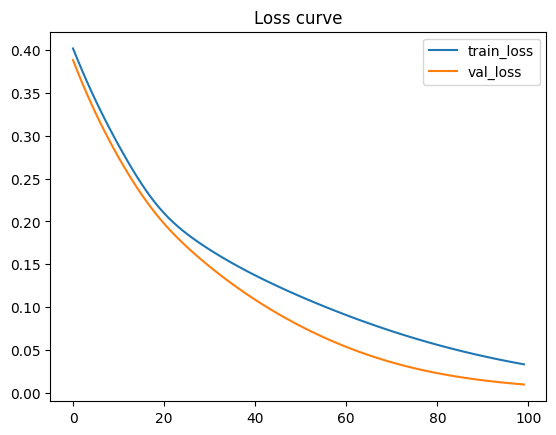

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# prepare datasets
if TRAIN_ON_TRAIN:
    dataset_train = tf.data.Dataset.from_tensor_slices(df_train_norm)
else:
    dataset_train = tf.data.Dataset.from_tensor_slices(df_all_norm)
dataset_train = dataset_train.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
dataset_train = dataset_train.prefetch(buffer_size=tf.data.AUTOTUNE)
dataset_val = tf.data.Dataset.from_tensor_slices(df_val_norm)
dataset_val = dataset_val.batch(batch_size=BATCH_SIZE, num_parallel_calls=tf.data.AUTOTUNE)
dataset_val = dataset_val.prefetch(buffer_size=tf.data.AUTOTUNE)
print('dataset prepared!')

# build the model
model = FunkSVDRecommender(m_users=M_USERS,
                           n_items=N_ITEMS,
                           bias_mu=BIAS_MU,
                           embedding_size=EMBEDDING_SIZE,
                           learning_rate=LEARNING_RATE,
                           learning_rate_update=LEARNING_RATE_UPDATE,
                           regularization_train=REGULARIZATION_TRAIN,
                           regularization_update=REGULARIZATION_UPDATE,
                           seed=SEED)
print('model set!')

# train the model
train_losses = []
val_losses = []

for epoch in range(1, N_EPOCHS + 1):
    train_loss = []
    val_loss = []
    print(f'Epoch {epoch}:')

    # training
    for data in tqdm(dataset_train, desc='Training'):
        loss = model.train_step(data)
        train_loss.append(loss.numpy())

    # validating
    for data in tqdm(dataset_val, desc='Validating'):
        loss = model.val_step(data)
        val_loss.append(loss.numpy())

    # record losses
    avg_train_loss = np.mean(train_loss)
    avg_val_loss = np.mean(val_loss)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # print losses
    print(f'Epoch {epoch} train_loss: {avg_train_loss:.4f}, val_loss: {avg_val_loss:.4f}\n')

# plot the training curve
plt.plot(train_losses, label='train_loss')
plt.plot(val_losses, label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss curve')
plt.show()


## Evaluate the model with the validation set

In [16]:
dataset_eval = tf.data.Dataset.from_tensor_slices(df_val)
dataset_eval = dataset_eval.prefetch(buffer_size=tf.data.AUTOTUNE)
ndcg_result, recall_result = evaluate(model, dataset_eval)
print(f'Evaluation result: [NDCG@10: {ndcg_result:.6f}, Recall@10: {recall_result:.6f}]')


Evaluating: 100%|██████████| 52089/52089 [01:59<00:00, 434.78it/s]


Evaluation result: [NDCG@10: 0.081139, Recall@10: 0.190541]


## Save the model

In [17]:
# save the model
model.save('funksvd_model')


INFO:tensorflow:Assets written to: funksvd_model/assets


In [18]:
!python evaluate_sample.py dataset/ratings_train.csv funksvd_model/


/home/anitalin/.bashrc: line 5: bind: warning: line editing not enabled
2 Physical GPUs, 1 Logical GPUs
Loading dataset from dataset/ratings_train.csv
Generating validation set: 100%|██████████| 6040/6040 [00:05<00:00, 1029.99it/s]
Loading model from funksvd_model/
Evaluating: 100%|████████████████████████| 52089/52089 [02:00<00:00, 432.50it/s]
Evaluation result: [NDCG@10: 0.096527, Recall@10: 0.213135]


## Report
### I. Models have tried during the competition.
- **FunkSVD**  
    FunkSVD是在Netflix電影推薦比賽中脫穎而出的一個推薦系統方法，為了簡化運算把傳統SVD的三個矩陣分解成兩個矩陣${P}^T_{mxk} Q_{kxn}$相乘來得到預測的Rating矩陣，其中m是user數量，n是item數量，k是factor數量（即可調整的embedding size)，相乘後的預測rating矩陣和已知rating相比計算loss function，並進一步以gradient descent來更新P和Q。這個方法相當間單，且速度快有一定的正確率。
    而在我們的實作當中，將原本的架構加入了bias term來模擬一些非典型用戶的行為或是經典電影給分分佈較特別的狀況，bias分成$b_u$和$b_i$兩項，分別表示user $u$ 和item $i$ 偏離平均的分數。舉例來說可能有人對電影比較嚴格，給的分數相對較低，或是某經典電影大家都給很高分，在這種狀況之下，喜好程度的狀況必須加上個別user和item的bias term才是真正的rating值。
  
- **Fatorization Machine**  
    另外我們也嘗試過Factorization Machine，是一種Model based的推薦系統，這個model的優勢在於能有效解決稀疏資料的特徵組合問題，時間複雜度也控制在linear time。
    在FM的feature vector中由多個欄位所組成，包含了UserID, MovieID, OtherMovieRated, Time, LastMovieRated, Target，其中UserID, MovieID以OneHot來對原本的數值encode，OtherMovieRated是將該用戶有rated的幾個OneHot欄位為1的位置除上看過電影的數量，Time是將原本unix timestamp轉乘datetime之後，由2000年1月開始計算月份數量，而lastMovieRated是前一部電影的OneHot encoding值，Target即為原本的rating值，從下圖中可以看到，他會是一個相當稀疏的矩陣。
      
    ![](fm.png)
      
    而model equation可近似成 $\hat{y}(x)=w_o+\sum^n_{i=1}w_ix_i+\sum^n_{i=1}\sum^n_{j=i+1}⟨v_i ,v_j⟩x_ix_j$，其中$⟨v_i ,v_j⟩$ 模擬第i和第j項的interaction，假設兩user對同部電影有相似評分，他們的user的factor vector就會相似，若同一個user對其中幾部電影有相似的評分，代表這些電影應該有些同質性，其factor vector應該也會相似。
    
### II. Experiments have done
- **FunkSVD**  
    對於funkSVD，我們將hyperparameter拿出來實驗，其中包含了embedding size, batch size, learning rate, 以及在update model時所使用的learning rate等等參數，另外也曾經在loss function中加入l2_norm term。在funkSVD的中加入update model的方式和train model時的方法相同，拿到當下的data計算其loss function並更新trainable variables。
    而在實驗結果上顯示，越大的embedding size其learning rate越小結果會更好，但調整embedding size對於整體的performance沒有太大的影響，我們最終是以embedding size = 256，搭配update model的方式在evaluation round4拿掉不錯的成績。另外針對update model時的learning rate我們也調整成較小一些的數字，在final round是以embedding size = 512，learning rate = 2e-5，update learning rate = 1e-5，最後出來的成績卻沒有理想中更好，是較為可惜的部分。
  
- **Fatorization Machine**  
    對於Factorization Machine的實驗，我們一開始實作上建立feature vector 就遇到了一些困難，原因是若在一開始就將userID, MovieID等等的數值以OneHot爆開並建立表格，會佔用掉的memory資源相當多，導致在我們的server上kernel crash掉的狀況，因此後來改變寫法，將feature vector中每一個row所需要的原始數值傳入dataset map function，再從map function中套用OneHot來展開後續需要用來做計算的矩陣。
    但是在後續的實作上發現其效果沒有funckSVD來得好，就算比起funkSVD多加入了timestamp的資訊做出的效果仍然比較差，因此最後沒有採用這種model作為最終的作法。

### III. Discussions
- **Lesson Learned**  
    這次的competition有嘗試去實作不同的recommendation system，由於有些碰壁和memory的限制問題，花了點時間才將FM實作出來。對䱷我們遇到的實作問題，我們有從memory上著手，降低資料的精度，也嘗試將FM中OtherMovieRating項的浮點數放大轉成整數來處理，也曾經使用寫出讀入一個一個row的pickle檔來解決memory上的問題，最後以map function解決這個問題。
      
- **Conclusion**  
   對於這次推薦系統的contest中，如果只調整model，而沒有去考量更多可能improve performance機會的方式可能較難達到好的結果，我們認為update model的方式可能是造成performance上升的主要原因，若能透過看到的data，已知越多的情況之下，用更精準的方式來更新model拿到更接近ground truth的rating，應該可以有更好的成果。
   另外針對一些沒有被拿出來使用的data，像是user的資訊，item(movie)的分類，可能可以再多做一些處理，加入model來增加預測時參考的對象，可惜在耗費太多時間在實作其他推薦系統，是比較可惜的部分。
    